In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## Prepare Dataset

In [3]:
train_df_path ='../07. Pemodelan Data (Data Mining)/dataset/Final_Dataset.csv'


In [4]:
train_df = pd.read_csv(train_df_path, sep=',', header=None, usecols=[0,1], skiprows=1)

train_df.columns = ['full_text', 'emotion']

In [5]:
train_df.head(10)

,full_text,emotion
0,"['pengabdian', 'terpuji', 'meskipun', 'terliha...",Neutral
1,"['baru', 'mengirim', 'foto']",Neutral
2,"['apa', 'kabar', 'dunia', 'twitter', 'masihkah...",Neutral
3,"['yah', 'gimana', 'sih', 'yaudah', 'susul', 's...",Neutral
4,"['ka', 'dorg', 'suro', 'beli', 'medium', 'set']",Neutral
5,"['ayo', 'cek', 'koleksinya', 'temukan', 'angry...",Neutral
6,"['kalau', 'biasa', 'biasa', 'sudah']",Neutral
7,"['tiap', 'tiap', 'twit', 'tak', 'selalu', 'per...",Neutral
8,"['halo', 'v', 'apa', 'kabar', 'nih']",Neutral
9,"['pagi', 'ruby', 'apa', 'kabar']",Neutral


In [6]:
train_df.head(10)

,full_text,emotion
0,"['pengabdian', 'terpuji', 'meskipun', 'terliha...",Neutral
1,"['baru', 'mengirim', 'foto']",Neutral
2,"['apa', 'kabar', 'dunia', 'twitter', 'masihkah...",Neutral
3,"['yah', 'gimana', 'sih', 'yaudah', 'susul', 's...",Neutral
4,"['ka', 'dorg', 'suro', 'beli', 'medium', 'set']",Neutral
5,"['ayo', 'cek', 'koleksinya', 'temukan', 'angry...",Neutral
6,"['kalau', 'biasa', 'biasa', 'sudah']",Neutral
7,"['tiap', 'tiap', 'twit', 'tak', 'selalu', 'per...",Neutral
8,"['halo', 'v', 'apa', 'kabar', 'nih']",Neutral
9,"['pagi', 'ruby', 'apa', 'kabar']",Neutral


In [7]:
def get_label_idx(label):
    if label == 'Fear':
        return 5
    if label == 'Sad':
        return 4
    if label == 'Love':
        return 3
    if label == 'Joy':
        return 2
    if label == 'Anger':
        return 1
    if label == 'Neutral':
        return 0


train_df['emotion'] = train_df['emotion'].apply(get_label_idx)

In [8]:
#hapus label selain 0-5
train_df = train_df[train_df['emotion'] <= 5]


In [9]:
# Define the function to join the list of tokens as a single document string
def join_text_list(texts):
    try:
        texts = ast.literal_eval(texts)
        return ' '.join([text for text in texts])
    except (ValueError, SyntaxError):
        return None  # or return an empty string if you prefer

# Apply the function to the 'full_text' column
train_df["full_text"] = train_df["full_text"].apply(join_text_list)

# Display the first few rows of the preprocessed column
train_df

,full_text,emotion
0,pengabdian terpuji meskipun terlihat biasa,0.0
1,baru mengirim foto,0.0
2,apa kabar dunia twitter masihkah selucu seabsu...,0.0
3,yah gimana sih yaudah susul sebelumnya sarapan...,0.0
4,ka dorg suro beli medium set,0.0
...,...,...
57295,cod beli euphoria wonderland la foret fairy ha...,2.0
57296,ลองด cod flash sale ก โล แมคคายกกระสอบ ต กก ต ...,2.0
57297,wal cod an shopee kawa pakai qris lah yuu,0.0
57298,temukan bisa cod light stick treasure bluetoot...,0.0


In [10]:
jumlah_netral = len(train_df[train_df['emotion'] == 0])
jumlah_marah = len(train_df[train_df['emotion'] == 1])
jumlah_senang = len(train_df[train_df['emotion'] == 2])
jumlah_cinta = len(train_df[train_df['emotion'] == 3])
jumlah_sedih = len(train_df[train_df['emotion'] == 4])
jumlah_takut = len(train_df[train_df['emotion'] == 5])

print("Jumlah Netral: ", jumlah_netral)
print("Jumlah Marah: ", jumlah_marah)
print("Jumlah Senang: ", jumlah_senang)
print("Jumlah Cinta: ", jumlah_cinta)
print("Jumlah Sedih: ", jumlah_sedih)
print("Jumlah Takut: ", jumlah_takut)

Jumlah Netral:  12981
Jumlah Marah:  11069
Jumlah Senang:  12307
Jumlah Cinta:  5389
Jumlah Sedih:  7272
Jumlah Takut:  7996


In [11]:
# Split dataset menjadi fitur (X) dan label (y)
X_train = train_df['full_text']
y_train = train_df['emotion']


In [12]:
##split dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [13]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((51312,), (5702,), (51312,), (5702,))

## Generate Padded Sequence

In [14]:
# Parameters

vocab_size = 60000 #ukuran kosakata yang akan digunakan
max_length = 50 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

# Define the "all_texts" variable
X_train = [str(text) for text in X_train]
X_valid = [str(text) for text in X_valid]

# Tokenisasi
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Gabungkan semua teks untuk membuat kamus indeks kata
all_texts = list(X_train) + list(X_valid)

# Membuat kamus indeks kata
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
word_index


# Konversi kalimat menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding="post")

valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type, padding="post")




### kamus data untuk api Training

In [16]:
# import pickle

# Simpan tokenizer ke dalam file
# with open('tokenizer-2classes-no-stemming.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [17]:
print(train_padded[0])

[ 3147  2262  3838    10   213  1188 12983    65    19    65    19  1935
   703   503  6033     6    20  1682   116    65    19     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


## Word Embedding

In [18]:
from gensim.models import Word2Vec

# Gabungkan data pelatihan dan validasi
sentences = [sentence.split() for sentence in X_train] + [sentence.split() for sentence in X_valid]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=1, workers=4)

In [19]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [20]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-3.87495446, -1.53844893, -1.62132001, ..., -2.19293714,
         2.60628366,  0.10336759],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [21]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[345])
print(word)

('rahajeng', array([ 1.7307198 , -1.41444254,  2.80991578, -1.34303439,  2.95960379,
       -3.81372213,  6.702703  , -0.67359281]))


## Build and Compile Model

In [22]:
# convert to bi-lstm model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

c:\Users\TEMP\miniconda3\envs\skripsi\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 8)          │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       140,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,806 (3.00 MB)

 Trainable params: 306,806 (1.17 MB)

 Non-trainable params: 480,000 (1.83 MB)

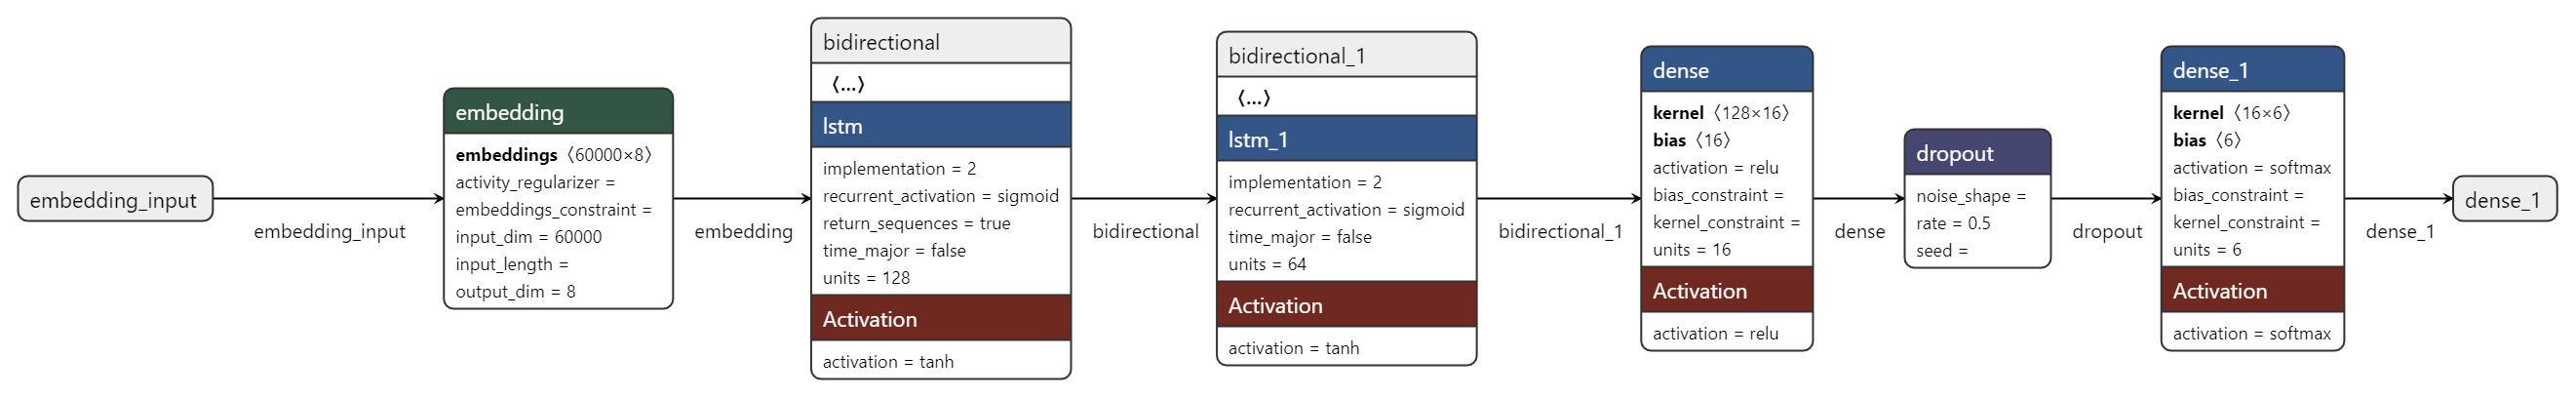

In [23]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding
Weights Shape (Tensor 0): (60000, 8)
Weights (Tensor 0):
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-3.8749545  -1.5384489  -1.62132    ... -2.1929371   2.6062837
   0.10336759]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Layer Name: bidirectional
Weights Shape (Tensor 0): (8, 512)
Weights (Tensor 0):
[[ 0.00421888  0.01544542  0.08137762 ... -0.02729834 -0.08228727
  -0.09586119]
 [ 0.07474058 -0.01418724 -0.02748568 ... -0.05001582  0.1058229
   0.04970039]
 [ 0.02580654  0.10133477 -0.00760765 ...  0.00224236  0.08396868
   0.00750092]
 ...
 [ 0.06140279  0.00485186 -0.07350305 ...  0.03822657  0.09461681
  -0.08079836]
 [-0.03245189 -0.05106873  0.06363607 ...  0.059041    0.0904

## Train Model

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = model.fit(
    train_padded, 
    y_train, 
    batch_size=128, 
    epochs=num_epochs, 
    validation_data=(valid_padded, y_valid), 
)

Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 94s 209ms/step - accuracy: 0.3464 - loss: 1.6179 - val_accuracy: 0.4528 - val_loss: 1.4022
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 75s 188ms/step - accuracy: 0.4212 - loss: 1.4720 - val_accuracy: 0.4665 - val_loss: 1.3768
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 74s 186ms/step - accuracy: 0.4412 - loss: 1.4324 - val_accuracy: 0.4893 - val_loss: 1.3388
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 74s 185ms/step - accuracy: 0.4556 - loss: 1.4036 - val_accuracy: 0.5102 - val_loss: 1.3041
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 75s 187ms/step - accuracy: 0.4736 - loss: 1.3674 - val_accuracy: 0.5210 - val_loss: 1.2621
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 76s 189ms/step - accuracy: 0.4875 - loss: 1.3425 - val_accuracy: 0.5223 - val_loss: 1.2576
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 77s 192ms/step - accuracy: 0.4965 - loss: 1.3223 - val_accuracy: 0.5260 - val_loss: 1.2339
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 84s 208ms/step - accuracy: 0.5000 - loss: 1

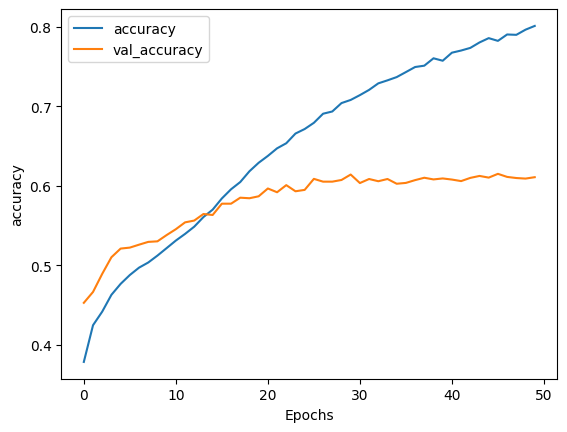

In [25]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

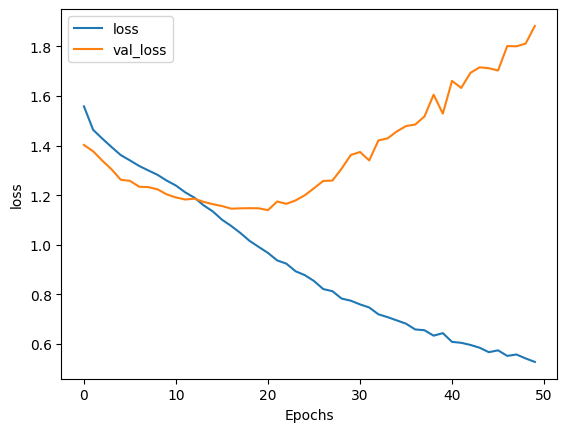

In [26]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [32]:
#sklearn report
from sklearn.metrics import classification_report

loss, accuracy = model.evaluate(valid_padded, y_valid)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

y_pred = model.predict(valid_padded)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_valid, y_pred))

179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6082 - loss: 1.9061
Loss:  1.881799340248108
Accuracy:  0.6108382940292358
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
              precision    recall  f1-score   support

         0.0       0.55      0.57      0.56      1333
         1.0       0.56      0.67      0.61      1028
         2.0       0.71      0.67      0.69      1249
         3.0       0.65      0.58      0.61       569
         4.0       0.63      0.65      0.64       709
         5.0       0.60      0.50      0.54       814

    accuracy                           0.61      5702
   macro avg       0.62      0.61      0.61      5702
weighted avg       0.61      0.61      0.61      5702



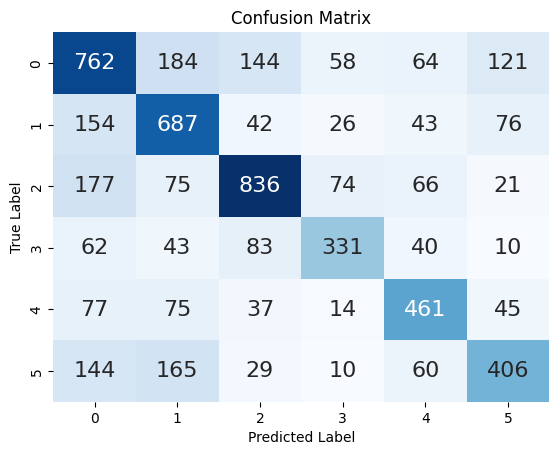

In [33]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Membuat confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Membuat heatmap dari confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [34]:
print(cm)

[[762 184 144  58  64 121]
 [154 687  42  26  43  76]
 [177  75 836  74  66  21]
 [ 62  43  83 331  40  10]
 [ 77  75  37  14 461  45]
 [144 165  29  10  60 406]]


In [40]:
#predict another data input from the model
def predict_emotion(text):
    # Tokenisasi
    text = [text]
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi
    pred = model.predict(padded)

    print("Prediksi:", pred)
    pred = np.argmax(pred, axis=1)
    

    # Mengembalikan label emosi
    if pred == 0:
        return "Neutral"
    elif pred == 1:
        return "Anger"
    elif pred == 2:
        return "Joy"
    elif pred == 3:
        return "Love"
    elif pred == 4:
        return "Sad"
    elif pred == 5:
        return "Fear"

#make 10 senteces twitter in predict emotion
predict_emotion("saya takut dengan hantu")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediksi: [[2.2796629e-04 6.7716797e-09 1.3531913e-10 2.2867499e-18 1.1903215e-06
  9.9977082e-01]]


'Fear'

In [41]:
#save model
model.save('./model/model-bilstm.h5')